# NHL Game Predictor
* How it works:
    * This will create the model based on the season of data
    * This will not make the estimates for a games in a season

In [2]:
# import pandas as pd
import numpy as np
import csv
import os
from pathlib import Path
import glob
from datetime import datetime
import matplotlib as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, train_test_split, RandomizedSearchCV
from sklearn import tree
from sklearn.metrics import roc_auc_score


ModuleNotFoundError: No module named 'numpy'

### Load files from data/games/*.csv directory
* The game_data is retrieved first for all the game data of the season
* Using game_data, the feature_data is populated which contains more scraped data from nhl.com

## Load the feature data

In [3]:
predictor_path = os.getcwd()
data_path = predictor_path.replace("model", "data/games/")
data_files = glob.glob(os.path.join(data_path,"feature_*.csv"))
data_files

['/Users/bwhitlock/repos/NHL_Predictor/data/games/feature_2018.csv',
 '/Users/bwhitlock/repos/NHL_Predictor/data/games/feature_2016.csv',
 '/Users/bwhitlock/repos/NHL_Predictor/data/games/feature_2017.csv']

In [4]:
seasons = []
for season_file in data_files:
    data = pd.read_csv(season_file, header=0)
    seasons.append(data)
df = pd.concat(seasons)

print ("Data for {} games.".format(df.shape[0]))
df.head()

Data for 3732 games.


,game_id,visitor_team,visitor_gp,visitor_w,visitor_l,visitor_t,visitor_ot,visitor_p,visitor_gf,visitor_ga,...,home_ts,home_ppga,home_pk%,home_fow,home_fol,home_fow%,home_goals,visitor_goals,extra_time,game_date
0,0,Calgary Flames,0,0,0,0,0,0,0,0,...,0,0,0.0,0,0,0.0,0,3,NaN,2017-10-04
1,1,St. Louis Blues,0,0,0,0,0,0,0,0,...,0,0,0.0,0,0,0.0,5,4,OT,2017-10-04
2,2,Philadelphia Flyers,0,0,0,0,0,0,0,0,...,0,0,0.0,0,0,0.0,5,3,NaN,2017-10-04
3,3,Toronto Maple Leafs,0,0,0,0,0,0,0,0,...,0,0,0.0,0,0,0.0,7,2,NaN,2017-10-04
4,4,Arizona Coyotes,0,0,0,0,0,0,0,0,...,0,0,0.0,0,0,0.0,4,5,NaN,2017-10-05


# Load the points data

In [5]:
predictor_path = os.getcwd()
data_path = predictor_path.replace("model", "data/points/")
points_files = glob.glob(os.path.join(data_path,"*.csv"))

print (points_files)
points = []
for file in points_files:
    data = pd.read_csv(file, header=0)
    points.append(data)
points_df = pd.concat(points)

print ("Data for {} games.".format(points_df.shape[0]))
points_df.head()

['/Users/bwhitlock/repos/NHL_Predictor/data/points/2018.csv', '/Users/bwhitlock/repos/NHL_Predictor/data/points/2016.csv', '/Users/bwhitlock/repos/NHL_Predictor/data/points/2017.csv']
Data for 91 games.


,team_name,year,points
0,Nashville Predators,2018,117
1,Winnipeg Jets,2018,114
2,Tampa Bay Lightning,2018,113
3,Boston Bruins,2018,112
4,Vegas Golden Knights,2018,109


# Combining Points and Game Data
* Ex: season 2017 contains data for the 16-17 season

## TODO: Account for Vegas

In [6]:
frames = []

for season in [2016, 2017, 2018]: 
    start_date = str(season-1) + "-07-01"
    end_date = str(season) + "-07-01"
    t = df[(df["game_date"] > start_date) & (df["game_date"] < end_date)]
    
    yearly_points = points_df[points_df["year"] == season]
    
    # home_points
    t = pd.merge(t, yearly_points, left_on='home_team', right_on='team_name')
    t = t.drop(columns=["team_name", "year"])
    t = t.rename(columns={"points": "home_points"})

    # visitor_points
    t = pd.merge(t, yearly_points, left_on = 'visitor_team', right_on = 'team_name')
    t = t.drop(columns=["team_name", "year"])
    t = t.rename(columns={"points": "visitor_points"})
    frames.append(t)
    
df = pd.concat(frames)


# List of possible features scraped from NHL.com

In [7]:
df.columns

Index(['game_id', 'visitor_team', 'visitor_gp', 'visitor_w', 'visitor_l',
       'visitor_t', 'visitor_ot', 'visitor_p', 'visitor_gf', 'visitor_ga',
       'visitor_s/o win', 'visitor_s/o loss', 'visitor_sf', 'visitor_sa',
       'visitor_ppg', 'visitor_pp opp', 'visitor_pp%', 'visitor_ts',
       'visitor_ppga', 'visitor_pk%', 'visitor_fow', 'visitor_fol',
       'visitor_fow%', 'home_team', 'home_gp', 'home_w', 'home_l', 'home_t',
       'home_ot', 'home_p', 'home_gf', 'home_ga', 'home_s/o win',
       'home_s/o loss', 'home_sf', 'home_sa', 'home_ppg', 'home_pp opp',
       'home_pp%', 'home_ts', 'home_ppga', 'home_pk%', 'home_fow', 'home_fol',
       'home_fow%', 'home_goals', 'visitor_goals', 'extra_time', 'game_date',
       'home_points', 'visitor_points'],
      dtype='object')

# Define the Target Variable

In [8]:
df["h_wins"] = df["home_goals"] > df["visitor_goals"]
df[["home_goals", "visitor_goals", "h_wins"]].head()

,home_goals,visitor_goals,h_wins
0,5,1,True
1,2,5,False
2,3,7,False
3,0,4,False
4,3,0,True


## Map the extra_time string to boolean

In [9]:
df = df.replace({'extra_time': {'SO': True, 'OT': True, np.NaN:False}})
df[["home_goals", "visitor_goals", "h_wins", "extra_time"]].head()


,home_goals,visitor_goals,h_wins,extra_time
0,5,1,True,False
1,2,5,False,False
2,3,7,False,False
3,0,4,False,False
4,3,0,True,False


# Remove some of the not relevant columns

In [10]:
suffix = ["gp", "w", "l", "t", "ot", "s/o win", "s/o loss", "pp opp", "ppg", "ppga", "fow", "fol"]
for prefix in ["visitor_", "home_"]:
    cols = [prefix+x for x in suffix]
    df = df.drop(columns=cols)


In [11]:
df.columns

Index(['game_id', 'visitor_team', 'visitor_p', 'visitor_gf', 'visitor_ga',
       'visitor_sf', 'visitor_sa', 'visitor_pp%', 'visitor_ts', 'visitor_pk%',
       'visitor_fow%', 'home_team', 'home_p', 'home_gf', 'home_ga', 'home_sf',
       'home_sa', 'home_pp%', 'home_ts', 'home_pk%', 'home_fow%', 'home_goals',
       'visitor_goals', 'extra_time', 'game_date', 'home_points',
       'visitor_points', 'h_wins'],
      dtype='object')

## Get the number of days since the last game for Visitor and Home team
* This is a way of defining momentum

In [12]:
df.columns

Index(['game_id', 'visitor_team', 'visitor_p', 'visitor_gf', 'visitor_ga',
       'visitor_sf', 'visitor_sa', 'visitor_pp%', 'visitor_ts', 'visitor_pk%',
       'visitor_fow%', 'home_team', 'home_p', 'home_gf', 'home_ga', 'home_sf',
       'home_sa', 'home_pp%', 'home_ts', 'home_pk%', 'home_fow%', 'home_goals',
       'visitor_goals', 'extra_time', 'game_date', 'home_points',
       'visitor_points', 'h_wins'],
      dtype='object')

In [13]:
def get_num_days(df, game_date, team_name):
    df = df[(df["game_date"] < game_date) & ((df["home_team"] == team_name) | 
                                             (df["visitor_team"] == team_name))]["game_date"]
    if df.empty:
        return 25
    else:
        d1 = datetime.strptime(game_date, '%Y-%m-%d')
        d0 = datetime.strptime(df.max(), '%Y-%m-%d')
        delta = d1 - d0
        return delta.days
    
for index, row in df.iterrows():
    for team_name in ["visitor", "home"]:
        df.loc[index, team_name+"_days_rest"] = get_num_days(df, row["game_date"], row[team_name+"_team"])


# Get the record of the teams last 5 games

In [14]:
def get_recent_record(df, row, team_name):
    is_home = team_name == "home"
    team_name = team_name + "_team"
    
    df = df[(df["game_date"] < row["game_date"]) & ((df["home_team"] == row[team_name]) | 
                                             (df["visitor_team"] == row[team_name]))][["h_wins", "extra_time"]]
    if df.empty:
        return 0
    else:
        df = df.iloc[-5:]
        points = 0
        for index, row in df.iterrows():
            if is_home and row["h_wins"]:
                points += 2
            elif is_home and not row["h_wins"] and row["extra_time"]:
                points += 1
            elif not is_home and not row["h_wins"]:
                points += 2
            elif not is_home and row["h_wins"] and row["extra_time"]:
                points += 1
        
        return points
    
for index, row in df.iterrows():
    for team_name in ["visitor", "home"]:
        df.loc[index, team_name+"_last_5"] = get_recent_record(df, row, team_name)


## Features
### Ratio is Home / Away
| Feature | Description |
| --- | --- |
| gf_r | Goals Ratio |
| ga_r | Goals Against Ratio |
| pp_r | Power Play Ratio |
| pk_r | Penalty Kill Ratio |
| shot_per_r | Shooting Percent Ratio |
| save_per_r | Save Percent Ratio |
| streak_r | Points in Last 5 Ratio |
| rest_r | Days Rest Ratio |
| last_pts_r | Last Seasons Points Ratio |

#### Future Considerations - Player considerations
| Feature | Description |
| --- | --- |
| Injuries | Are there any players injured on each team? |
| Star players | Does one team have star players, may be good for early season games | 
| Depth | Depth of team |
| Randomness | Hockey is a game of luck how can we include this in some way |

In [15]:
df.columns

Index(['game_id', 'visitor_team', 'visitor_p', 'visitor_gf', 'visitor_ga',
       'visitor_sf', 'visitor_sa', 'visitor_pp%', 'visitor_ts', 'visitor_pk%',
       'visitor_fow%', 'home_team', 'home_p', 'home_gf', 'home_ga', 'home_sf',
       'home_sa', 'home_pp%', 'home_ts', 'home_pk%', 'home_fow%', 'home_goals',
       'visitor_goals', 'extra_time', 'game_date', 'home_points',
       'visitor_points', 'h_wins', 'visitor_days_rest', 'home_days_rest',
       'visitor_last_5', 'home_last_5'],
      dtype='object')

#### Feature Columns

### What if there was a better way to impute the *NaN* and *inf* values in X? Averages?

In [64]:
X = pd.DataFrame()
X["gf_r"] = df["home_gf"] / df["visitor_gf"]
X["ga_r"] = df["home_ga"] / df["visitor_ga"]
X["pp_r"] = df["home_pp%"] / df["visitor_pp%"]
X["pk_r"] = df["home_pk%"] / df["visitor_pk%"]
X["shot_per_r"] = (df["home_gf"] / df["home_sf"]) / (df["visitor_gf"] / df["visitor_sf"])
X["save_per_r"] = (df["home_ga"] / df["home_sa"]) / (df["visitor_ga"] / df["visitor_sa"])
X["streak_r"] = df["home_last_5"] / df["visitor_last_5"]
#X["rest_r"] = df["home_days_rest"] / df["visitor_days_rest"] # Might not be useful
X["last_pts_r"] = df["home_points"] / df["visitor_points"]
X["curr_pts_r"] = df["home_p"] / df["visitor_p"]
#X = X.fillna(0)
#X = X.replace([np.inf, -np.inf], 10)
#m = df.loc[df['Crime_Rate'] != np.inf, 'Crime_Rate'].max()

In [65]:
# Replace np.inf with largest value in column 
for col in X.columns:
    if np.inf in X[col].unique():
        mx = X.loc[X[col] != np.inf, col].max()
        X[col].replace(np.inf, mx, inplace=True)

In [66]:
# Replace 0/0 with mean of column
for col in X.columns:
    if X[col].isnull().any():
        mean = X[col].mean()
        X[col].fillna(mean, inplace=True)

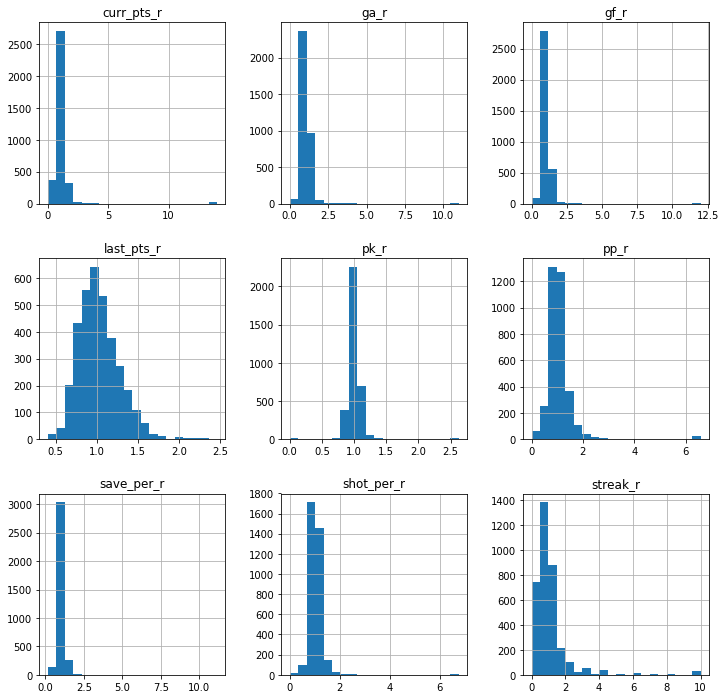

In [67]:
_ = X.hist(
        figsize=(12,12), 
        bins=20
    )

#### Target Column

In [68]:
y = pd.DataFrame()
y = df["h_wins"]

# Modelling
* If we set max_features=None and bootstrap=False then all trees will be the same since the "randomeness" is gone

In [69]:
rfc = RandomForestClassifier(
            n_estimators = 43,
            criterion = "gini", # This is default
            max_features = 0.4, # None: Use all features to make the cut, Float: use percentage
            min_samples_leaf = 1,
            min_samples_split = 15,
            max_depth = 5,
            bootstrap = True    # Default is True, true uses approx 2/3 of record in a tree, false uses all
        )
model = rfc.fit(X, y)


In [70]:
for i, j in zip(X.columns, rfc.feature_importances_):
    print ('Feature: {:10s}  Importance: {:7.2f}'.format(i, j*100))

v_results = cross_validate(model, X, y, return_train_score=False, cv=3)
v_results

Feature: gf_r        Importance:    7.36
Feature: ga_r        Importance:    9.62
Feature: pp_r        Importance:    7.53
Feature: pk_r        Importance:    6.07
Feature: shot_per_r  Importance:    7.45
Feature: save_per_r  Importance:    8.06
Feature: streak_r    Importance:    3.51
Feature: last_pts_r  Importance:   39.47
Feature: curr_pts_r  Importance:   10.92


{'fit_time': array([0.15672016, 0.14066505, 0.12691689]),
 'score_time': array([0.00609589, 0.00564098, 0.00573421]),
 'test_score': array([0.59965636, 0.60017197, 0.61962134])}

# Testing

In [71]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

rfc.fit(X_train, Y_train)

Y_pred = np.zeros(X_test.shape[0])
Y_pred = rfc.predict_proba(X_test)[:, 1]

print ("ROC Score: ", roc_auc_score(Y_test, Y_pred))


ROC Score:  0.630170195923214


# Hyperparameter Tuning: Random Hyperparameter Grid

In [322]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 15, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [323]:
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(
                estimator = rf, 
                param_distributions = random_grid, 
                n_iter = 100, 
                cv = 3, 
                random_state=42, 
                n_jobs = -1
            )

# Fit the random search model
rf_random.fit(X, y)

# Best Parameters
rf_random.best_params_

{'n_estimators': 43,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 0.4,
 'max_depth': 5,
 'bootstrap': True}

# Export to DOT file to view tree

In [286]:
tree_1 = rfc.estimators_[2]
tree.export_graphviz(
        tree_1,
        out_file='tree2.dot',
        proportion=True
) 